In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
skaters = pd.read_csv('data/skaters.csv')

In [3]:
skaters = skaters.drop(columns=['Unnamed: 0'])

In [4]:
skaters.head(10)

,vote-share,goals,assists,ops,dps,plus-minus,mvp,position_C,position_D,position_W,points,tps
0,38.43,51,86,11.3,1.3,14,1,1,0,0,137,12.6
1,30.24,53,84,11.6,2.0,34,0,1,0,0,137,13.6
2,8.01,50,75,10.8,2.0,40,0,0,0,1,125,12.8
3,3.64,56,33,8.3,2.1,48,0,0,0,1,89,10.4
4,1.64,14,61,5.5,5.9,38,0,0,1,0,75,11.4
5,1.46,40,57,7.7,1.0,3,0,1,0,0,97,8.7
6,1.28,8,33,3.2,2.4,13,0,0,1,0,41,5.6
7,1.09,12,57,3.3,1.6,42,0,1,0,0,69,4.9
8,42.68,55,109,12.3,2.0,41,1,1,0,0,164,14.3
9,4.23,58,77,10.5,2.3,54,0,1,0,0,135,12.8


In [5]:
skaterX = skaters.drop(columns=['vote-share', 'mvp', 'dps'])
skaterY = skaters['mvp']

sx_train, sx_test, sy_train, sy_test = train_test_split(skaterX, skaterY, test_size=0.2, random_state=33, shuffle=True, stratify=skaterY)

In [6]:
columns_to_scale = ['goals', 'assists', 'ops', 'plus-minus', 'points', 'tps']
columns_no_scale = [col for col in sx_train.columns if col not in columns_to_scale]

scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('no_scaler', 'passthrough', columns_no_scale)
    ]
)

sx_train = scaler.fit_transform(sx_train)
sx_test = scaler.transform(sx_test)

In [7]:
sx_train = pd.DataFrame(sx_train, columns=(columns_to_scale + columns_no_scale))
sx_test = pd.DataFrame(sx_test, columns=(columns_to_scale + columns_no_scale))

In [8]:
smote = SMOTE(random_state=33, k_neighbors=10)
sx_train_smote, sy_train_smote = smote.fit_resample(sx_train, sy_train)

In [9]:
rf_classifier = RandomForestClassifier(random_state=33)

rf_classifier.fit(sx_train_smote, sy_train_smote)

RandomForestClassifier(random_state=33)

In [10]:
sy_pred = rf_classifier.predict(sx_test)

accuracy = accuracy_score(sy_test, sy_pred)
precision = precision_score(sy_test, sy_pred, average='binary')
recall = recall_score(sy_test, sy_pred, average='binary')
f1 = f1_score(sy_test, sy_pred, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.94
Precision: 0.50
Recall: 0.88
F1 Score: 0.64


In [11]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')

grid_search.fit(sx_train_smote, sy_train_smote)
tuned_rf = grid_search.best_estimator_

sy_pred = tuned_rf.predict(sx_test)

accuracy = accuracy_score(sy_test, sy_pred)
precision = precision_score(sy_test, sy_pred, average='binary')
recall = recall_score(sy_test, sy_pred, average='binary')
f1 = f1_score(sy_test, sy_pred, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


C:\Users\tommy\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Accuracy: 0.95
Precision: 0.54
Recall: 0.88
F1 Score: 0.67


In [12]:
grid_search.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [13]:
cm = confusion_matrix(sy_test, sy_pred)
cm

array([[121,   6],
       [  1,   7]])

In [14]:
sy_test.sum()

np.int64(8)

In [15]:
sy_pred.sum()

np.int64(13)

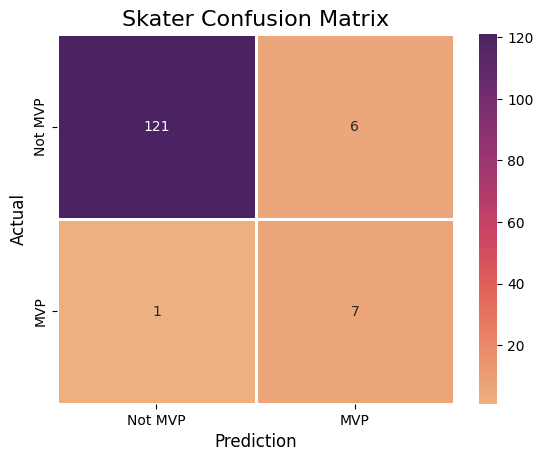

<Figure size 640x480 with 0 Axes>

In [16]:
sns.heatmap(cm, annot=True, xticklabels=['Not MVP', 'MVP'], yticklabels=['Not MVP', 'MVP'], cmap='flare',
            fmt='g', linecolor='white', linewidth=1
        )
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Skater Confusion Matrix', fontsize=16)
plt.show()
plt.savefig('data/skater_confusion.png')

In [17]:
scores = tuned_rf.predict_proba(sx_test)

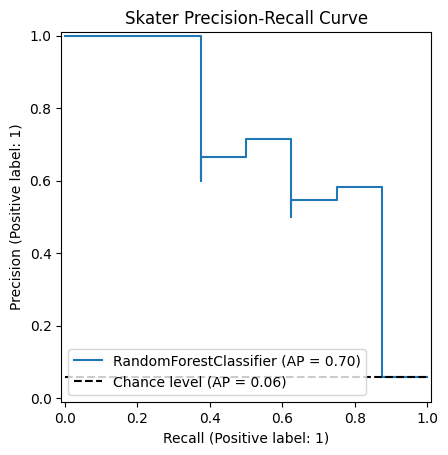

<Figure size 640x480 with 0 Axes>

In [18]:
display = PrecisionRecallDisplay.from_predictions(
    sy_test, scores[:, 1], name='RandomForestClassifier', plot_chance_level=True
)

display.ax_.set_title('Skater Precision-Recall Curve')
plt.show()
plt.savefig('data/skaterPRC.png')